In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import seaborn as sb

from Bio import SeqIO

sb.set()
pd.set_option("display.max_rows", None)

# Evaluation of DADA2 on Callahan data

The following notebook describes the steps and results of the evaluation.

In [ ]:
# Initial files and directories:
#
# dada2_callahan
# |- data
# |  |- balanced
# |  |  \- BalancedRefSeqs.fasta  # provided reference sequences of 'balanced' data set
# |  |
# |  \- hmp
# |     \- HMP_MOCK.fasta  # provided reference sequences of 'hmp' data set
# |
# |- evaluation # will contain the evaluation plots and tables
# |
# \- outputs # will contain the cluster and metric outputs

The provided reference sequences are part of the [Supplementary Software](https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.3869/MediaObjects/41592_2016_BFnmeth3869_MOESM270_ESM.zip) of the DADA2 paper.   

## Analysis workflow

The data sets are preprocessed as described in Callahan et al., *DADA2: High-resolution sample inference from Illumina amplicon data* (https://doi.org/10.1038/nmeth.3869),
except that the minimum sequence abundance is set to 1 (not 2) for the sake of a fair comparison with the other data sets and tools.

The taxonomic assignment is obtained by merging the reads (using `USEARCH -fastq_mergepairs`) and matching them with the respective reference sequences (using `VSEARCH --usearch_global`).

The DADA2 pipeline is executed as in Callahan et al. (dereplication -- DADA2 -- chimera detection -- output sample sequences) and, in addition,
we reconstruct the OTUs corresponding to the sample sequences (both with and without chimera filtering).

## Commands

The following commands prepare and cluster the data sets. The results are evaluated below.

In order to execute the workflow as provided here, the `tools` subdirectory of the overall repository should contain the USEARCH binaries `usearch8.0.1623_i86linux32` and `usearch10.0.240_i86linux32`, but the paths can be adjusted.   
In addition, VSEARCH is expected to be accessible through the `vsearch` command.

IMPORTANT: The commands are not intended to be executed from this notebook. They should be executed from the root directory of the overall repository.

In [ ]:
%%bash

ANALYSIS_DIR=analyses/dada2_callahan
DATA_DIR=${ANALYSIS_DIR}/data
OUTPUT_DIR=${ANALYSIS_DIR}/outputs

USEARCH8_PATH=${TOOLS_DIR}/usearch8.0.1623_i86linux32 # adjust to your system
USEARCH10_PATH=${TOOLS_DIR}/usearch10.0.240_i86linux32 # adjust to your system

## balanced
python -m scripts.analyses.analysis_callahan reference balanced ${DATA_DIR}/balanced/BalancedRefSeqs.fasta ${DATA_DIR}/balanced/callahan.fasta 

# paired
python -m scripts.analyses.analysis_callahan prepare balanced ${DATA_DIR}/balanced --min_size 1 --usearch8 ${USEARCH8_PATH} --usearch10 ${USEARCH10_PATH}
python -m scripts.analyses.analysis_callahan taxonomy ${DATA_DIR}/balanced/ERR777695_pfm.fastq ${DATA_DIR}/balanced/callahan.fasta ${DATA_DIR}/balanced/bp_callahan_0.97.tax 0.97
python -m scripts.analyses.analysis_callahan run_dada2 bp ${DATA_DIR}/balanced/ERR777695_1_pf.fastq ${OUTPUT_DIR}/balanced_paired -r ${DATA_DIR}/balanced/ERR777695_2_pf.fastq --tax_files callahan:${DATA_DIR}/balanced/bp_callahan_0.97.tax

# single
python -m scripts.analyses.analysis_callahan prepare balanced ${DATA_DIR}/balanced --single --min_size 1 --usearch8 ${USEARCH8_PATH} --usearch10 ${USEARCH10_PATH}
python -m scripts.analyses.analysis_callahan taxonomy ${DATA_DIR}/balanced/ERR777695_1_sf.fastq ${DATA_DIR}/balanced/callahan.fasta ${DATA_DIR}/balanced/bs_callahan_0.97.tax 0.97
python -m scripts.analyses.analysis_callahan run_dada2 bs ${DATA_DIR}/balanced/ERR777695_1_sf.fastq ${OUTPUT_DIR}/balanced_single --tax_files callahan:${DATA_DIR}/balanced/bs_callahan_0.97.tax

## hmp
python -m scripts.analyses.analysis_callahan reference hmp ${DATA_DIR}/hmp/HMP_MOCK.fasta ${DATA_DIR}/hmp/callahan.fasta 

# paired
python -m scripts.analyses.analysis_callahan prepare hmp ${DATA_DIR}/hmp --min_size 1 --usearch8 ${USEARCH8_PATH} --usearch10 ${USEARCH10_PATH}
python -m scripts.analyses.analysis_callahan taxonomy ${DATA_DIR}/hmp/Mock1_S1_L001_pfm.fastq ${DATA_DIR}/hmp/callahan.fasta ${DATA_DIR}/hmp/hp_callahan_0.97.tax 0.97
python -m scripts.analyses.analysis_callahan run_dada2 hp ${DATA_DIR}/hmp/Mock1_S1_L001_R1_001_pf.fastq ${OUTPUT_DIR}/hmp_paired -r ${DATA_DIR}/hmp/Mock1_S1_L001_R2_001_pf.fastq --tax_files callahan:${DATA_DIR}/hmp/hp_callahan_0.97.tax

# single
python -m scripts.analyses.analysis_callahan prepare hmp ${DATA_DIR}/hmp --single --min_size 1 --usearch8 ${USEARCH8_PATH} --usearch10 ${USEARCH10_PATH}
python -m scripts.analyses.analysis_callahan taxonomy ${DATA_DIR}/hmp/Mock1_S1_L001_R1_001_sf.fastq ${DATA_DIR}/hmp/callahan.fasta ${DATA_DIR}/hmp/hs_callahan_0.97.tax 0.97
python -m scripts.analyses.analysis_callahan run_dada2 hs ${DATA_DIR}/hmp/Mock1_S1_L001_R1_001_sf.fastq ${OUTPUT_DIR}/hmp_single --tax_files callahan:${DATA_DIR}/hmp/hs_callahan_0.97.tax

## Evaluation

**Configuration**

In [2]:
data_sets = ['balanced', 'hmp']
read_types = ['single', 'paired']
ground_truths = ['callahan']

opts = ['dada2', 'dada2_nc']

read_files = {'balanced_single': 'ERR777695_1_sf.fastq', 'balanced_paired': 'ERR777695_1_pf.fastq',
              'hmp_single': 'Mock1_S1_L001_R1_001_sf.fastq', 'hmp_paired': 'Mock1_S1_L001_R1_001_pf.fastq'}

data_dir = 'data'
results_dir = 'outputs'
eval_dir = 'evaluation'

### Number of clusters and amplicons

Reads the input files and the cluster outputs for all data sets and compares the number of clusters and amplicons.

In [3]:
# Requires the input and OTU files. Alternatively, the evaluation can use the stored information (see below).
df_columns = ['data_set', 'tool', 'mode', 'refinement', 'threshold', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass', 'ds', 'rt']

rows = []

for ds in data_sets:
    for rt in read_types:
        run_name = '%s_%s' % (ds, rt)

        seq_file = '%s/%s/%s' % (data_dir, ds, read_files[run_name]) # the input sequences
        num_input_amplicons = 0
        input_mass = 0
        with open(seq_file, 'r') as in_file:
            for record in SeqIO.parse(in_file, 'fastq'):
                num_input_amplicons += 1
                input_mass += int(record.id.split('_')[-1]) if ('_' in record.id) else 1

        for opt in opts:
            otu_file = '%s/%s_%s/%s_%s_otus.txt' % (results_dir, ds, rt, ds[0] + rt[0], opt)

            num_output_amplicons = 0
            num_clusters = 0
            output_mass = 0
            with open(otu_file, 'r') as in_file:
                for line in in_file:
                    num_output_amplicons += len(line.strip().split(' '))
                    num_clusters += 1
                    output_mass += sum([int(m.split('_')[-1]) for m in line.strip().split(' ')])

            tool = 'dada2'
            mode = 'non-chimeric' if 'nc' in opt else 'chimeric'
            refinement = 'nf'
            threshold = 0.0

            rows.append([run_name, tool, mode, refinement, threshold, num_input_amplicons, input_mass, num_clusters, num_output_amplicons, output_mass, ds, rt])

df_counts = pd.DataFrame(rows, columns = df_columns)

*Column descriptions:*   
`num_input_amplicons`: The number of entries in the corresponding input file.   
`input_mass`: The sum of the abundances of all entries in the input file.   
`num_clusters`: The number of reconstructed clusters corresponding to the sample sequences determined by DADA2.   
`num_output_amplicons`: The number of amplicons contained in the reconstructed clusters.   
`output_mass`: The sum of the abundances of all amplicons contained in the reconstructed clusters.   

In [4]:
df_counts[['data_set', 'mode', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass']]

,data_set,mode,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass
0,balanced_single,chimeric,558059,558059,341,556655,556655
1,balanced_single,non-chimeric,558059,558059,94,552728,552728
2,balanced_paired,chimeric,493046,493046,304,474031,474031
3,balanced_paired,non-chimeric,493046,493046,88,469530,469530
4,hmp_single,chimeric,449409,449409,625,447838,447838
5,hmp_single,non-chimeric,449409,449409,174,424629,424629
6,hmp_paired,chimeric,303363,303363,737,292480,292480
7,hmp_paired,non-chimeric,303363,303363,110,279096,279096


In [5]:
df_counts.to_csv('%s/df_counts.csv' % eval_dir, sep = ';', index = False)
#df_counts = pd.read_csv('%s/df_counts.csv' % eval_dir, sep = ';')

Graphical representation of the cluster and amplicon counts:

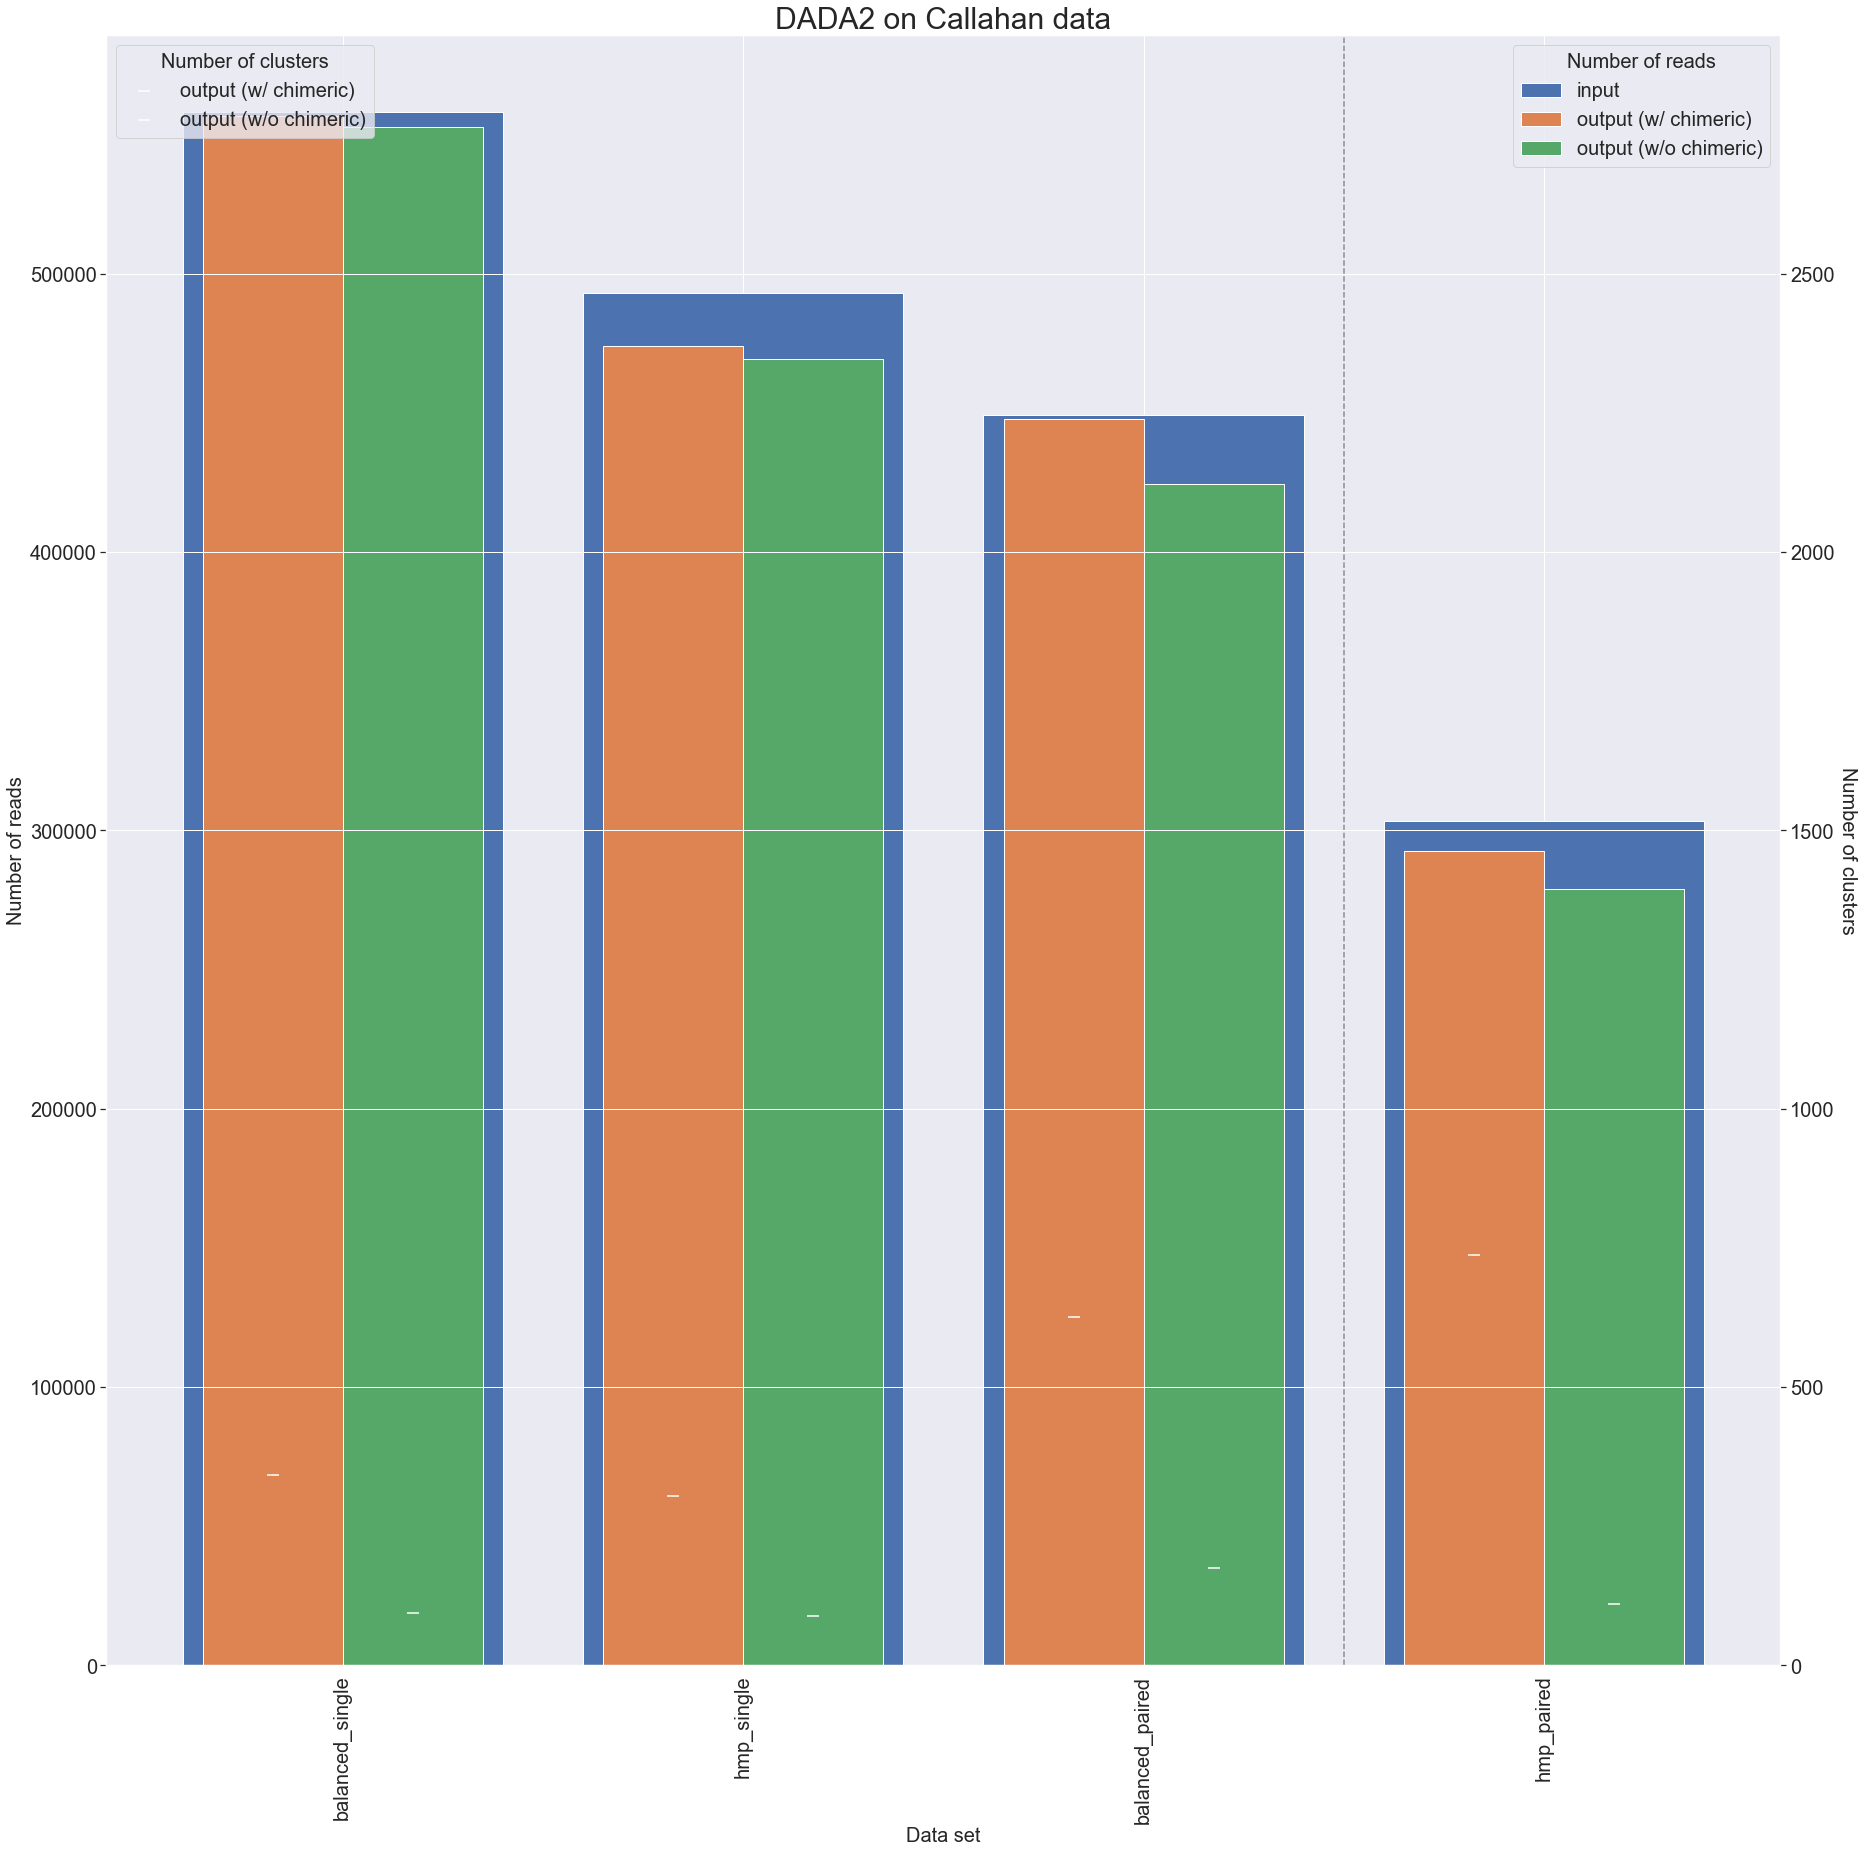

In [6]:
fig, ax = plt.subplots(figsize = (30, 30))
pos = range(0, len(df_counts['data_set'].unique()))

df_c = df_counts.loc[df_counts['mode'] == 'chimeric']
df_nc = df_counts.loc[df_counts['mode'] == 'non-chimeric']

ax.bar(pos, df_c['num_input_amplicons'], label = 'input')
ax.bar([p - 0.175 for p in pos], df_c['num_output_amplicons'], width = 0.35, label = 'output (w/ chimeric)')
ax.bar([p + 0.175 for p in pos], df_nc['num_output_amplicons'], width = 0.35, label = 'output (w/o chimeric)')
ax.set_xlabel('Data set', fontsize = 20)
ax.set_xticks(pos)
ax.set_xticklabels(['%s_%s' % (ds, rt) for rt in read_types for ds in data_sets], rotation = 90)
ax.set_ylabel('Number of reads', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

ax.axvline(2.5, color = 'black', linestyle = 'dashed', alpha = 0.4)

ax2 = ax.twinx()
ax2.plot([0],[0])
ax2.scatter([p - 0.175 for p in pos], list(df_c['num_clusters']), label = 'output (w/ chimeric)', 
            marker = '_', s = 150, color = 'w')
ax2.scatter([p + 0.175 for p in pos], list(df_nc['num_clusters']), label = 'output (w/o chimeric)',
            marker = '_', s = 150, color = 'w')

ax2.set_ylabel('Number of clusters', rotation = 270, va = 'bottom', fontsize = 20)
ax2.tick_params(axis = 'y', labelsize = 20)

leg = ax.legend(fontsize = 20)
leg.set_title('Number of reads', prop = {'size': 20})

leg2 = ax2.legend(fontsize = 20, loc = 2)
leg2.set_title('Number of clusters', prop = {'size': 20})

ax2.set_ylim((ax.get_ylim()[0] / 200, ax.get_ylim()[1] / 200));
ax.set_title('DADA2 on Callahan data', fontsize = 30);

Additional statistics on the cluster and amplicon counts:

In [7]:
df_counts_single = df_counts.copy().loc[df_counts['rt'] == 'single']
df_counts_paired = df_counts.copy().loc[df_counts['rt'] == 'paired']

**Single reads**

*Proportion of input read kept in output clusters*

With chimeric:

In [8]:
print('Minimum: %f' % (df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.996504
Average: 0.996994 (SD: 0.000693)
Maximum: 0.997484


Without chimeric:

In [9]:
print('Minimum: %f' % (df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_single.loc[df_counts_single['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.944861
Average: 0.967654 (SD: 0.032234)
Maximum: 0.990447


**Paired reads**

*Proportion of input reads kept in output clusters*

With chimeric:

In [10]:
print('Minimum: %f' % (df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.961434
Average: 0.962780 (SD: 0.001903)
Maximum: 0.964125


Without chimeric:

In [11]:
print('Minimum: %f' % (df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_paired.loc[df_counts_paired['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.920007
Average: 0.936156 (SD: 0.022838)
Maximum: 0.952305


### Clustering quality

In [12]:
# Requires the metrics files. Alternatively, the evaluation can use the stored information (see below).
dfs = []
for ds in data_sets:
    for rt in read_types:
        run_name = '%s_%s' % (ds, rt)

        for gt in ground_truths:
            df = pd.read_csv('%s/%s_%s/%s_%s__metrics.csv' % (results_dir, ds, rt, ds[0] + rt[0], gt), sep = ';')

            df['reads'] = '%s_%s' % (ds, rt)
            df['gt'] = gt
            df['mode'] = ['non-chimeric' if 'nc' in m else 'chimeric' for m in df['task']]
            df['refinement'] = 'nf'
            df['ds'] = ds
            df['rt'] = rt

            dfs.append(df)
                    
df_quality = pd.concat(dfs, ignore_index = True)
df_quality.rename(columns = {'task': 'run', 'reads': 'data_set'}, inplace = True)
for c in ['threshold', 'precision', 'recall', 'adjrandindex']:
    df_quality[c] = df_quality[c].astype(float)

*Column descriptions:*   
`precision`: Quantifies the extent to which amplicons in a cluster are also from the same species.   
`recall`: Measures the proportion of amplicons from the same species that are grouped in the same cluster.   
`adjrandindex`: Measures the agreement between the clusters and the taxonomic assignment and corrects for chance.   

In [13]:
df_quality[['data_set', 'gt', 'mode', 'precision', 'recall', 'adjrandindex']]

,data_set,gt,mode,precision,recall,adjrandindex
0,balanced_single,callahan,chimeric,0.996324,0.942135,0.956877
1,balanced_single,callahan,non-chimeric,0.997176,0.948828,0.964113
2,balanced_paired,callahan,chimeric,0.953096,0.901165,0.844043
3,balanced_paired,callahan,non-chimeric,0.953588,0.909803,0.856444
4,hmp_single,callahan,chimeric,0.987085,0.905734,0.909105
5,hmp_single,callahan,non-chimeric,0.991249,0.955239,0.958164
6,hmp_paired,callahan,chimeric,0.705491,0.535821,0.227644
7,hmp_paired,callahan,non-chimeric,0.701827,0.561516,0.257015


In [14]:
df_quality.to_csv('%s/df_quality.csv' % eval_dir, sep = ';', index = False)
#df_quality = pd.read_csv('%s/df_quality.csv' % eval_dir, sep = ';')

Combine counting and quality information:

In [15]:
df_c, df_q = df_counts.copy(), df_quality.copy()
drop_cols = ['join_col'] + ['%s_counts' % s for s in set(df_q.columns) & set(df_c.columns)]
df_c['join_col'] = df_c['data_set'] + df_c['tool'] + df_c['mode'] + df_c['refinement'] + df_c['threshold'].apply(str)
df_q['join_col'] = df_q['data_set'] + df_q['tool'] + df_q['mode'] + df_q['refinement'] + df_q['threshold'].apply(str)
df_joined = df_q.join(df_c.set_index('join_col'), on = 'join_col', rsuffix = '_counts').drop(drop_cols, axis = 1)

In [16]:
df_joined.to_csv('%s/df_joined.csv' % eval_dir, sep = ';', index = False)
#df_joined = pd.read_csv('%s/df_joined.csv' % eval_dir, sep = ';')

Determine the maximum, average and N-best average clustering quality (for N = 5).

In [17]:
df_columns = ['data_set', 'gt', 'tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass', 'ds', 'rt']

max_rows = []
mean_rows = []
nbest_rows = []
n = 5

for (d, g, t, m, f, ds, rt), grp in df_joined.groupby(by = ['data_set', 'gt', 'tool', 'mode', 'refinement', 'ds', 'rt']):
    best = grp.nlargest(1, 'adjrandindex')
    max_rows.append([d, g, t, m, f, best['precision'].values[0], best['recall'].values[0], best['adjrandindex'].values[0], best['num_input_amplicons'].values[0], best['input_mass'].values[0], best['num_clusters'].values[0], best['num_output_amplicons'].values[0], best['output_mass'].values[0], ds, rt])
    mean_rows.append([d, g, t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean(), grp['num_input_amplicons'].mean(), grp['input_mass'].mean(), grp['num_clusters'].mean(), grp['num_output_amplicons'].mean(), grp['output_mass'].mean(), ds, rt])
    nbest = grp.nlargest(n, 'adjrandindex')
    nbest_rows.append([d, g, t, m, f, nbest['precision'].mean(), nbest['recall'].mean(), nbest['adjrandindex'].mean(), nbest['num_input_amplicons'].mean(), nbest['input_mass'].mean(), nbest['num_clusters'].mean(), nbest['num_output_amplicons'].mean(), nbest['output_mass'].mean(), ds, rt])
    
df_joined_max = pd.DataFrame(max_rows, columns = df_columns)
df_joined_mean = pd.DataFrame(mean_rows, columns = df_columns)
df_joined_nbest = pd.DataFrame(nbest_rows, columns = df_columns)

In [18]:
df_joined_max.to_csv('%s/df_joined_max.csv' % eval_dir, sep = ';', index = False)
df_joined_mean.to_csv('%s/df_joined_mean.csv' % eval_dir, sep = ';', index = False)
df_joined_nbest.to_csv('%s/df_joined_nbest.csv' % eval_dir, sep = ';', index = False)
#df_joined_max = pd.read_csv('%s/df_joined_max.csv' % eval_dir, sep = ';')
#df_joined_mean = pd.read_csv('%s/df_joined_mean.csv' % eval_dir, sep = ';')
#df_joined_nbest = pd.read_csv('%s/df_joined_nbest.csv' % eval_dir, sep = ';')

In [19]:
df_max = df_joined_max.loc[df_joined_max['gt'] == 'callahan']
df_mean = df_joined_mean.loc[df_joined_mean['gt'] == 'callahan']
df_nbest = df_joined_nbest.loc[df_joined_nbest['gt'] == 'callahan']

For the chosen ground truth, average the maximum, average and N-best average values per data set (e.g. balanced) and read type (e.g. paired).   
Has no effect in this case because there is only one data set per combination of data set and read type .

In [20]:
df_columns = ['data_set', 'gt', 'tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass', 'ds', 'rt']

def average_complexity(df):
    rows = []
    for (gt, ds, rt, tool, mode, f), grp in df.groupby(by = ['gt', 'ds', 'rt', 'tool', 'mode', 'refinement']):
        rows.append(['%s_%s' % (ds, rt), gt, tool, mode, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean(), grp['num_input_amplicons'].mean(), grp['input_mass'].mean(), grp['num_clusters'].mean(), grp['num_output_amplicons'].mean(), grp['output_mass'].mean(), ds, rt])
    return pd.DataFrame(rows, columns = df_columns)

In [21]:
df_joined_max_avg = average_complexity(df_max)
df_joined_mean_avg = average_complexity(df_mean)
df_joined_nbest_avg = average_complexity(df_nbest)

In [22]:
df_joined_max_avg.to_csv('%s/df_joined_max_avg.csv' % eval_dir, sep = ';', index = False)
df_joined_mean_avg.to_csv('%s/df_joined_mean_avg.csv' % eval_dir, sep = ';', index = False)
df_joined_nbest_avg.to_csv('%s/df_joined_nbest_avg.csv' % eval_dir, sep = ';', index = False)
#df_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % eval_dir, sep = ';')
#df_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % eval_dir, sep = ';')
#df_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % eval_dir, sep = ';')

**Maximum clustering quality**

Rank by adjusted Rand index (per data set):

In [23]:
for (d, t), grp in df_joined_max_avg.groupby(by = ['data_set', 'tool']):
    print('Data set: %s / Tool: %s' % (d, t))
    display(grp.sort_values(by = 'adjrandindex', ascending = False))

Data set: balanced_paired / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
1,balanced_paired,callahan,dada2,non-chimeric,nf,0.953588,0.909803,0.856444,493046.0,493046.0,88.0,469530.0,469530.0,balanced,paired
0,balanced_paired,callahan,dada2,chimeric,nf,0.953096,0.901165,0.844043,493046.0,493046.0,304.0,474031.0,474031.0,balanced,paired


Data set: balanced_single / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
3,balanced_single,callahan,dada2,non-chimeric,nf,0.997176,0.948828,0.964113,558059.0,558059.0,94.0,552728.0,552728.0,balanced,single
2,balanced_single,callahan,dada2,chimeric,nf,0.996324,0.942135,0.956877,558059.0,558059.0,341.0,556655.0,556655.0,balanced,single


Data set: hmp_paired / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
5,hmp_paired,callahan,dada2,non-chimeric,nf,0.701827,0.561516,0.257015,303363.0,303363.0,110.0,279096.0,279096.0,hmp,paired
4,hmp_paired,callahan,dada2,chimeric,nf,0.705491,0.535821,0.227644,303363.0,303363.0,737.0,292480.0,292480.0,hmp,paired


Data set: hmp_single / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
7,hmp_single,callahan,dada2,non-chimeric,nf,0.991249,0.955239,0.958164,449409.0,449409.0,174.0,424629.0,424629.0,hmp,single
6,hmp_single,callahan,dada2,chimeric,nf,0.987085,0.905734,0.909105,449409.0,449409.0,625.0,447838.0,447838.0,hmp,single


Non-chimeric (slightly) better on each data set.

Average the maximum values over all data sets and sort by adjusted Rand index:

In [24]:
rows = []
for (t, m, f), grp in df_joined_max_avg.groupby(by = ['tool', 'mode', 'refinement']):
    rows.append([t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean()])
pd.DataFrame(rows, columns = ['tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex']).sort_values(by = 'adjrandindex', ascending = False)

,tool,mode,refinement,precision,recall,adjrandindex
1,dada2,non-chimeric,nf,0.910960,0.843847,0.758934
0,dada2,chimeric,nf,0.910499,0.821214,0.734417


**Average clustering quality**

Rank by adjusted Rand index (per data set):

In [25]:
for (d, t), grp in df_joined_mean_avg.groupby(by = ['data_set', 'tool']):
    print('Data set: %s / Tool: %s' % (d, t))
    display(grp.sort_values(by = 'adjrandindex', ascending = False))

Data set: balanced_paired / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
1,balanced_paired,callahan,dada2,non-chimeric,nf,0.953588,0.909803,0.856444,493046.0,493046.0,88.0,469530.0,469530.0,balanced,paired
0,balanced_paired,callahan,dada2,chimeric,nf,0.953096,0.901165,0.844043,493046.0,493046.0,304.0,474031.0,474031.0,balanced,paired


Data set: balanced_single / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
3,balanced_single,callahan,dada2,non-chimeric,nf,0.997176,0.948828,0.964113,558059.0,558059.0,94.0,552728.0,552728.0,balanced,single
2,balanced_single,callahan,dada2,chimeric,nf,0.996324,0.942135,0.956877,558059.0,558059.0,341.0,556655.0,556655.0,balanced,single


Data set: hmp_paired / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
5,hmp_paired,callahan,dada2,non-chimeric,nf,0.701827,0.561516,0.257015,303363.0,303363.0,110.0,279096.0,279096.0,hmp,paired
4,hmp_paired,callahan,dada2,chimeric,nf,0.705491,0.535821,0.227644,303363.0,303363.0,737.0,292480.0,292480.0,hmp,paired


Data set: hmp_single / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
7,hmp_single,callahan,dada2,non-chimeric,nf,0.991249,0.955239,0.958164,449409.0,449409.0,174.0,424629.0,424629.0,hmp,single
6,hmp_single,callahan,dada2,chimeric,nf,0.987085,0.905734,0.909105,449409.0,449409.0,625.0,447838.0,447838.0,hmp,single


Same tendency as maximum.

Average the mean values over all data sets and sort by adjusted Rand index.

In [26]:
rows = []
for (t, m, f), grp in df_joined_mean_avg.groupby(by = ['tool', 'mode', 'refinement']):
    rows.append([t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean()])
pd.DataFrame(rows, columns = ['tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex']).sort_values(by = 'adjrandindex', ascending = False)

,tool,mode,refinement,precision,recall,adjrandindex
1,dada2,non-chimeric,nf,0.910960,0.843847,0.758934
0,dada2,chimeric,nf,0.910499,0.821214,0.734417


**N-best average clustering quality**

Rank by adjusted Rand index (per data set):

In [27]:
for (d, t), grp in df_joined_nbest_avg.groupby(by = ['data_set', 'tool']):
    print('Data set: %s / Tool: %s' % (d, t))
    display(grp.sort_values(by = 'adjrandindex', ascending = False))

Data set: balanced_paired / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
1,balanced_paired,callahan,dada2,non-chimeric,nf,0.953588,0.909803,0.856444,493046.0,493046.0,88.0,469530.0,469530.0,balanced,paired
0,balanced_paired,callahan,dada2,chimeric,nf,0.953096,0.901165,0.844043,493046.0,493046.0,304.0,474031.0,474031.0,balanced,paired


Data set: balanced_single / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
3,balanced_single,callahan,dada2,non-chimeric,nf,0.997176,0.948828,0.964113,558059.0,558059.0,94.0,552728.0,552728.0,balanced,single
2,balanced_single,callahan,dada2,chimeric,nf,0.996324,0.942135,0.956877,558059.0,558059.0,341.0,556655.0,556655.0,balanced,single


Data set: hmp_paired / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
5,hmp_paired,callahan,dada2,non-chimeric,nf,0.701827,0.561516,0.257015,303363.0,303363.0,110.0,279096.0,279096.0,hmp,paired
4,hmp_paired,callahan,dada2,chimeric,nf,0.705491,0.535821,0.227644,303363.0,303363.0,737.0,292480.0,292480.0,hmp,paired


Data set: hmp_single / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
7,hmp_single,callahan,dada2,non-chimeric,nf,0.991249,0.955239,0.958164,449409.0,449409.0,174.0,424629.0,424629.0,hmp,single
6,hmp_single,callahan,dada2,chimeric,nf,0.987085,0.905734,0.909105,449409.0,449409.0,625.0,447838.0,447838.0,hmp,single


Same tendencies as maximum.

Average the N-best values over all data sets and sort by adjusted Rand index.

In [28]:
rows = []
for (t, m, f), grp in df_joined_nbest_avg.groupby(by = ['tool', 'mode', 'refinement']):
    rows.append([t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean()])
pd.DataFrame(rows, columns = ['tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex']).sort_values(by = 'adjrandindex', ascending = False)

,tool,mode,refinement,precision,recall,adjrandindex
1,dada2,non-chimeric,nf,0.910960,0.843847,0.758934
0,dada2,chimeric,nf,0.910499,0.821214,0.734417
